# Task 3a Code for Preparing Model

In [1]:

#Importing required Libraries

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from matplotlib import pyplot as plt
import time
import os
import copy
from PIL import Image
from torch.utils.data import Dataset
import pandas as pd
import torchvision.transforms as transforms


In [2]:




def create_meta_csv(dataset_path, destination_path):
    """Create a meta csv file given a dataset folder path of images.

    This function creates and saves a meta csv file named 'dataset_attr.csv' given a dataset folder path of images.
    The file will contain images and their labels. This file can be then used to make
    train, test and val splits, randomize them and load few of them (a mini-batch) in memory
    as required. The file is saved in dataset_path folder if destination_path is not provided.

    The purpose behind creating this file is to allow loading of images on demand as required. Only those images required are loaded randomly but on demand using their paths.

    Args:
        dataset_path (str): Path to dataset folder
        destination_path (str): Destination to store meta file if None provided, it'll store file in dataset_path

    Returns:
        True (bool): Returns True if 'dataset_attr.csv' was created successfully else returns an exception
    """

    # Change dataset path accordingly
    class_names={}
    temp_dir=os.getcwd()
    dataset_path=os.chdir(dataset_path)
    j=-1
        
    for i in os.listdir():
        if os.path.isdir(i):
            j+=1
            os.chdir(i)
            class_names[j]=i
            os.chdir('..')

    if 'dataset_attr.csv' not in os.listdir():

        # Make a csv with full file path and labels
        d=[]
        
        j=-1
        for i in os.listdir():
            j+=1
            print(j)
            os.chdir(i)
            class_names[j]=i
            for img in os.listdir():
                temp=os.getcwd()+'\\'+img,j
                a=Image.open(temp[0])
                a=np.array(a)
                if len(a.shape)==3 and a.shape[2]==3:
                    d.append(temp)
            os.chdir('..')
        df=pd.DataFrame(d,columns=['path','label'])

        # change destination_path to DATASET_PATH if destination_path is None
        if destination_path == None:
            destination_path = os.getcwd()

        # write out as dataset_attr.csv in destination_path directory
        df.to_csv('dataset_attr.csv')

        # if no error
    os.chdir(temp_dir)
    return class_names

def create_and_load_meta_csv_df(dataset_path, destination_path, randomize=True, split=None):
    """Create a meta csv file given a dataset folder path of images and loads it as a pandas dataframe.

    This function creates and saves a meta csv file named 'dataset_attr.csv' given a dataset folder path of images.
    The file will contain images and their labels. This file can be then used to make
    train, test and val splits, randomize them and load few of them (a mini-batch) in memory
    as required. The file is saved in dataset_path folder if destination_path is not provided.

    The function will return pandas dataframes for the csv and also train and test splits if you specify a
    fraction in split parameter.

    Args:
        dataset_path (str): Path to dataset folder
        destination_path (str): Destination to store meta csv file
        randomize (bool, optional): Randomize the csv records. Defaults to True
        split (double, optional): Percentage of train records. Defaults to None

    Returns:
        dframe (pandas.Dataframe): Returns a single Dataframe for csv if split is none, else returns more two Dataframes for train and test splits.
        train_set (pandas.Dataframe): Returns a Dataframe of length (split) * len(dframe)
        test_set (pandas.Dataframe): Returns a Dataframe of length (1 - split) * len(dframe)
    """
    class_names=create_meta_csv(dataset_path, destination_path=destination_path)
    if class_names:
        os.chdir(dataset_path)
        dframe = pd.read_csv(os.getcwd()+'\\dataset_attr.csv')

    # shuffle if randomize is True or if split specified and randomize is not specified
    # so default behavior is split
    if randomize == True or (split != None and randomize == None):
        # shuffle the dataframe here

        dframe = dframe.sample(frac=1).reset_index(drop=True)
        pass

    if split != None:
        train_set, test_set = train_test_split(dframe, split)
        return dframe, train_set, test_set ,class_names

    return dframe , class_names

def train_test_split(dframe, split_ratio):
    """Splits the dataframe into train and test subset dataframes.

    Args:
        split_ration (float): Divides dframe into two splits.

    Returns:
        train_data (pandas.Dataframe): Returns a Dataframe of length (split_ratio) * len(dframe)
        test_data (pandas.Dataframe): Returns a Dataframe of length (1 - split_ratio) * len(dframe)
    """
    # divide into train and test dataframes
    train_data=dframe[:int(len(dframe)*split_ratio)]
    test_data=dframe[int(len(dframe)*split_ratio):]
    os.chdir('../..')
    return train_data, test_data

class ImageDataset(Dataset):
    """Image Dataset that works with images

    This class inherits from torch.utils.data.Dataset and will be used inside torch.utils.data.DataLoader
    Args:
        data (str): Dataframe with path and label of images.
        transform (torchvision.transforms.Compose, optional): Transform to be applied on a sample. Defaults to None.

    Examples:
        >>> df, train_df, test_df = create_and_load_meta_csv_df(dataset_path, destination_path, randomize=randomize, split=0.99)
        >>> train_dataset = dataset.ImageDataset(train_df)
        >>> test_dataset = dataset.ImageDataset(test_df, transform=...)
    """

    def __init__(self, data, transform=None):
        self.data = data
        self.transform =torchvision.transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
        self.classes = data['label'].unique()# get unique classes from data dataframe
        

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]['path']
        image = Image.open(img_path)# load PIL image
        
        label = self.data.iloc[idx]['label']# get label (derived from self.classes; type: int/long) of image

        if self.transform:
            image = self.transform(image)

        return image, label


        


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
#Preparing Dataframe 
dataset_path=destination_path='./Data/Animals Dataset/'
df, train_df, test_df, class_names = create_and_load_meta_csv_df(dataset_path, destination_path, randomize=True, split=0.9)

In [5]:
#Preparing Train Loader
train_dataset=ImageDataset(train_df)

train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=128,
                                               shuffle=True)

In [6]:
#Preparing Test Loader
test_dataset=ImageDataset(test_df)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=128,
                                            shuffle=True)

In [7]:
#Dictionaries for data loader and data size
dataloaders={'train': train_loader,
              'val': test_loader}

dataset_sizes = {'train':len(train_df),'val':len(test_df)}


In [8]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    fig=plt.figure(figsize=(5, 5))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

'''
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
fig=plt.figure(figsize=(20, 20))
imshow(out, title=[class_names[int(x)] for x in classes])
'''

"\n# Get a batch of training data\ninputs, classes = next(iter(dataloaders['train']))\n\n# Make a grid from batch\nout = torchvision.utils.make_grid(inputs)\nfig=plt.figure(figsize=(20, 20))\nimshow(out, title=[class_names[int(x)] for x in classes])\n"

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        x=0
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for (inputs, labels) in dataloaders[phase]:
                 
                
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                
                    
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [10]:
#Visualizing the model....
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[int(preds[j])]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [12]:
#Defining the model...
model_ft = models.resnet18()

model_ft.fc=nn.Linear(512,38)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Epoch 0/0
----------
tensor([[[[ 1.8722,  1.8379,  1.8208,  ...,  1.2043,  1.4098,  1.5982],
          [ 1.8208,  1.8037,  1.8037,  ...,  1.2557,  1.4612,  1.7180],
          [ 1.7352,  1.7180,  1.7352,  ...,  1.3070,  1.5982,  1.8550],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -1.3987, -1.3815, -1.2959],
          [-2.1179, -2.1008, -2.1008,  ..., -1.3644, -1.4672, -1.4158],
          [-2.1008, -2.1008, -2.0837,  ..., -1.3473, -1.3473, -1.4329]],

         [[ 2.3585,  2.3060,  2.2885,  ...,  1.4132,  1.5357,  1.6408],
          [ 2.3060,  2.2710,  2.2710,  ...,  1.4657,  1.5882,  1.7633],
          [ 2.2185,  2.2010,  2.2010,  ...,  1.5007,  1.7108,  1.9034],
          ...,
          [-1.9307, -1.9482, -1.9482,  ..., -1.2479, -1.2129, -1.1253],
          [-1.9832, -1.9657, -1.9482,  ..., -1.2129, -1.3004, -1.2479],
          [-2.0357, -2.0182, -2.0182,  ..., -1.1954, -1.1779, -1.2654]],

         [[ 2.5877,  2.5529,  2.5354,  ...,  1.4025,  1.5768,  1.7860],
         

tensor([[[[-0.7308, -0.8678, -1.1247,  ..., -1.6898, -2.0323, -2.1179],
          [-0.7479, -0.9192, -1.1932,  ..., -1.7925, -2.0323, -2.1008],
          [-1.0048, -1.2274, -1.4500,  ..., -1.9980, -2.1008, -2.1179],
          ...,
          [-1.9467, -1.7925, -1.7754,  ..., -1.1418, -0.7993, -0.0801],
          [-1.4672, -1.5357, -1.5870,  ..., -0.9363, -0.2513,  0.0056],
          [-1.7583, -1.9124, -1.6042,  ..., -0.0801, -0.4739, -0.2171]],

         [[-0.4601, -0.6001, -0.8978,  ..., -1.4055, -1.7556, -1.8782],
          [-0.5126, -0.6877, -0.9503,  ..., -1.5105, -1.7556, -1.8256],
          [-0.7927, -1.0203, -1.2479,  ..., -1.7206, -1.8606, -1.8957],
          ...,
          [-2.0357, -1.9307, -1.9132,  ..., -1.4230, -1.1253, -0.3901],
          [-1.5455, -1.6155, -1.6681,  ..., -1.2129, -0.5126, -0.2500],
          [-1.8256, -1.9832, -1.6681,  ..., -0.3200, -0.7402, -0.4776]],

         [[ 0.0256, -0.1138, -0.3927,  ..., -1.0724, -1.4210, -1.5430],
          [-0.0092, -0.1835, -

tensor([[[[ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          ...,
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489]],

         [[ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
          [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
          [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
          ...,
          [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
          [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
          [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286]],

         [[ 2.6400,  2.6400,  2.6400,  ...,  2.6400,  2.6400,  2.6400],
          [ 2.6400,  2.6400,  

tensor([[[[-0.6794, -0.7308, -0.7993,  ...,  0.8789,  1.0159,  1.2557],
          [-0.6623, -0.7137, -0.7650,  ...,  0.9988,  1.1187,  1.2043],
          [-0.6452, -0.6794, -0.7479,  ...,  1.0159,  1.1015,  1.1529],
          ...,
          [ 0.8104,  0.8789,  0.9646,  ..., -0.7479, -0.7993, -0.7650],
          [ 0.8276,  0.7077,  0.7762,  ..., -0.7822, -0.7822, -0.7822],
          [ 0.9132,  0.8104,  0.8104,  ..., -0.7479, -0.7479, -0.7650]],

         [[-0.5651, -0.6176, -0.6877,  ...,  0.4328,  0.5728,  0.8354],
          [-0.5476, -0.6001, -0.6527,  ...,  0.5553,  0.6779,  0.8004],
          [-0.5301, -0.6176, -0.6352,  ...,  0.5903,  0.6779,  0.7304],
          ...,
          [ 0.7654,  0.8354,  0.9580,  ..., -0.8627, -0.9153, -0.8803],
          [ 0.7829,  0.6604,  0.7479,  ..., -0.8978, -0.8978, -0.8803],
          [ 0.8880,  0.8004,  0.8004,  ..., -0.8627, -0.8627, -0.8803]],

         [[-0.3055, -0.3578, -0.4624,  ..., -0.1312,  0.0082,  0.3219],
          [-0.2881, -0.3404, -

tensor([[[[ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          ...,
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489]],

         [[ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
          [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
          [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
          ...,
          [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
          [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
          [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286]],

         [[ 2.6400,  2.6400,  2.6400,  ...,  2.6400,  2.6400,  2.6400],
          [ 2.6400,  2.6400,  

tensor([[[[-0.4054, -0.2342, -0.0116,  ...,  0.0569,  0.0569,  0.1254],
          [-0.4739, -0.2684, -0.0801,  ...,  0.4851,  0.4508,  0.4166],
          [-0.1143, -0.0116,  0.0741,  ...,  0.0398,  0.0741, -0.0116],
          ...,
          [ 0.3652,  0.7248,  0.4337,  ...,  1.0502,  0.1083, -1.3473],
          [-0.6623, -0.5767, -0.8164,  ...,  1.3070, -0.0287, -1.5528],
          [-1.1418, -1.0219, -0.9192,  ...,  0.9646,  0.1426, -0.6965]],

         [[-0.6352, -0.4426, -0.2500,  ...,  0.9405,  0.9230,  0.9930],
          [-0.7052, -0.4951, -0.3200,  ...,  1.3782,  1.3431,  1.3081],
          [-0.3375, -0.2325, -0.1625,  ...,  0.9230,  0.9580,  0.8704],
          ...,
          [ 1.0980,  1.4657,  1.1856,  ...,  1.2906,  0.3277, -1.1429],
          [ 0.0651,  0.1527, -0.1450,  ...,  1.4832,  0.1352, -1.3704],
          [-0.4251, -0.3025, -0.2325,  ...,  1.1331,  0.2752, -0.5476]],

         [[-0.8807, -0.7413, -0.5670,  ...,  1.3154,  1.3502,  1.4200],
          [-0.9156, -0.7413, -

tensor([[[[ 0.6906,  0.8276,  0.7933,  ...,  0.6563,  0.5536,  0.6906],
          [ 0.7419,  0.7077,  0.6734,  ...,  0.6392,  0.4851,  0.5707],
          [ 0.6392,  0.6392,  0.7077,  ...,  0.5022,  0.5364,  0.5364],
          ...,
          [ 0.7248,  0.6049,  0.3652,  ...,  1.3242,  1.3927,  1.1872],
          [ 1.2557,  0.8618,  0.4679,  ...,  1.2899,  1.5125,  1.1187],
          [ 1.2385,  1.1015,  0.8447,  ...,  1.2043,  1.3927,  0.9988]],

         [[ 0.9755,  1.1155,  1.0980,  ...,  1.0105,  0.8880,  1.0280],
          [ 1.1155,  1.0630,  1.0105,  ...,  1.0280,  0.9055,  0.9755],
          [ 1.0455,  1.0105,  1.0455,  ...,  0.9230,  0.9580,  1.0105],
          ...,
          [ 0.6604,  0.6078,  0.3452,  ...,  1.5357,  1.6057,  1.3957],
          [ 1.2206,  0.9055,  0.4853,  ...,  1.5182,  1.7283,  1.3256],
          [ 1.2031,  1.0630,  0.8529,  ...,  1.3606,  1.5707,  1.1681]],

         [[ 0.8274,  0.9319,  0.8797,  ...,  0.6182,  0.5136,  0.6705],
          [ 0.7925,  0.7751,  

tensor([[[[-1.9124, -1.9467, -1.9124,  ..., -1.0048, -0.9877, -0.9363],
          [-1.3302, -1.3302, -1.3644,  ..., -1.0562, -1.0390, -1.0048],
          [-0.9363, -0.8678, -0.8335,  ..., -1.0562, -1.0562, -1.0390],
          ...,
          [-1.5185, -1.5870, -1.6213,  ..., -1.0733, -0.9877, -0.8849],
          [-1.4843, -1.5185, -1.5357,  ..., -1.0733, -1.0562, -0.9877],
          [-1.4843, -1.4500, -1.4672,  ..., -1.2788, -1.2274, -1.1418]],

         [[-1.3179, -1.3529, -1.3529,  ..., -0.5476, -0.4951, -0.4076],
          [-0.8277, -0.8277, -0.8627,  ..., -0.6001, -0.5476, -0.5126],
          [-0.5301, -0.4601, -0.4076,  ..., -0.6001, -0.6001, -0.5826],
          ...,
          [-1.1954, -1.2654, -1.2829,  ..., -0.3200, -0.1975, -0.1450],
          [-1.1429, -1.1954, -1.1954,  ..., -0.5476, -0.3901, -0.3025],
          [-1.1253, -1.1078, -1.1253,  ..., -0.7752, -0.6527, -0.4776]],

         [[-1.7522, -1.7696, -1.7522,  ..., -1.1596, -1.0724, -0.9853],
          [-1.3164, -1.3164, -

tensor([[[[-0.8507, -1.0048, -1.0904,  ...,  0.1597,  0.2111,  0.2453],
          [-0.8164, -0.9534, -1.0562,  ...,  0.0741,  0.1426,  0.1939],
          [-0.7822, -0.9192, -1.0048,  ...,  0.0056,  0.0912,  0.1597],
          ...,
          [-1.6213, -1.6384, -0.3541,  ...,  0.6049,  0.7248,  0.8276],
          [-0.9877, -0.8507, -1.0562,  ...,  0.7762,  0.1426,  0.1939],
          [ 0.0569, -0.1314, -0.9363,  ...,  0.3823, -0.9020, -0.6965]],

         [[-0.9153, -1.0728, -1.1604,  ...,  0.2052,  0.2227,  0.2577],
          [-0.8803, -1.0203, -1.1253,  ...,  0.1352,  0.1702,  0.2227],
          [-0.8452, -0.9853, -1.0728,  ...,  0.0476,  0.1352,  0.1702],
          ...,
          [-1.6856, -1.7206, -0.4776,  ...,  0.2227,  0.3452,  0.4503],
          [-1.0728, -0.9503, -1.2304,  ...,  0.4328, -0.2150, -0.1625],
          [-0.0399, -0.2675, -1.1078,  ...,  0.0301, -1.2829, -1.0728]],

         [[-0.7238, -0.8807, -0.9678,  ...,  1.1237,  1.1585,  1.1934],
          [-0.6890, -0.8284, -

tensor([[[[-1.8097, -1.7240, -1.6898,  ..., -0.8507, -1.0390, -1.2103],
          [-1.7754, -1.7754, -1.7583,  ..., -0.5938, -0.7650, -0.9705],
          [-1.8097, -1.8268, -1.8953,  ..., -0.4739, -0.5767, -0.7650],
          ...,
          [-0.4739, -0.0801,  0.4851,  ...,  0.8104,  0.5878,  0.3994],
          [-0.0972,  0.3138,  0.6734,  ...,  0.7419,  0.4851,  0.3138],
          [ 0.2796,  0.2796,  0.8447,  ...,  0.4337,  0.3652,  0.2796]],

         [[-0.6877, -0.5651, -0.4951,  ...,  0.3102,  0.2227,  0.0826],
          [-0.6352, -0.6001, -0.5126,  ...,  0.4503,  0.4153,  0.3452],
          [-0.7052, -0.6702, -0.6702,  ...,  0.5028,  0.5028,  0.4328],
          ...,
          [-0.2850,  0.1176,  0.6954,  ...,  0.2927, -0.0399, -0.4076],
          [ 0.0476,  0.5028,  0.9230,  ...,  0.1176, -0.1099, -0.4076],
          [ 0.4328,  0.5203,  1.1506,  ..., -0.2500, -0.2675, -0.3901]],

         [[-1.7696, -1.6999, -1.6650,  ..., -0.8633, -1.2119, -1.5081],
          [-1.7522, -1.7522, -

tensor([[[[-0.5767, -0.4911, -0.4568,  ..., -1.0733, -0.9020, -0.7479],
          [-0.5767, -0.5082, -0.4397,  ..., -0.6794, -0.4911, -0.3198],
          [-0.5596, -0.5082, -0.4739,  ..., -0.3369, -0.1486,  0.0227],
          ...,
          [ 0.9988,  1.1529,  1.2385,  ..., -1.2617, -1.1589, -1.1075],
          [ 1.0673,  1.2214,  1.3070,  ..., -1.2103, -1.1418, -1.1075],
          [ 1.1015,  1.2214,  1.2557,  ..., -1.0219, -1.1418, -1.1589]],

         [[-0.2850, -0.2150, -0.1800,  ..., -0.9853, -0.8102, -0.6527],
          [-0.2850, -0.1975, -0.1625,  ..., -0.5826, -0.3901, -0.2150],
          [-0.2500, -0.1975, -0.1625,  ..., -0.2325, -0.0399,  0.1527],
          ...,
          [ 1.1506,  1.3081,  1.3957,  ..., -1.1253, -0.9853, -0.8978],
          [ 1.2206,  1.3782,  1.4657,  ..., -1.0728, -0.9853, -0.8978],
          [ 1.2381,  1.3606,  1.3957,  ..., -0.8978, -0.9678, -0.9503]],

         [[-0.8284, -0.7761, -0.7413,  ..., -0.7587, -0.6018, -0.4450],
          [-0.8110, -0.7413, -

tensor([[[[-0.7822, -0.8164, -0.8335,  ..., -0.6281, -0.5596, -0.5082],
          [-0.7650, -0.8164, -0.8164,  ..., -0.5596, -0.4911, -0.4397],
          [-0.8849, -0.9705, -0.9705,  ..., -0.5082, -0.4739, -0.4568],
          ...,
          [ 1.8893,  2.0092,  2.0434,  ...,  0.0056, -0.0116, -0.0287],
          [ 1.8550,  1.9578,  2.0777,  ..., -0.0287, -0.0458, -0.0458],
          [ 1.8208,  1.9064,  2.1119,  ..., -0.0458, -0.0629, -0.0629]],

         [[-0.6702, -0.7052, -0.7402,  ..., -0.4951, -0.4426, -0.3901],
          [-0.6352, -0.6877, -0.7052,  ..., -0.4251, -0.3725, -0.3200],
          [-0.6702, -0.7927, -0.7927,  ..., -0.3725, -0.3550, -0.3375],
          ...,
          [ 1.9209,  1.9559,  1.9209,  ...,  0.4503,  0.4328,  0.4153],
          [ 1.8859,  1.9034,  1.9559,  ...,  0.4153,  0.3978,  0.3978],
          [ 1.8508,  1.8508,  1.9909,  ...,  0.3978,  0.3803,  0.3803]],

         [[-0.5147, -0.4624, -0.4275,  ..., -0.3578, -0.2532, -0.1835],
          [-0.4973, -0.4624, -

tensor([[[[ 0.6563,  0.6392,  0.6392,  ..., -1.5185, -1.6042, -1.6042],
          [ 0.6734,  0.6392,  0.6049,  ..., -1.5699, -1.5870, -1.5870],
          [ 0.6221,  0.6049,  0.5536,  ..., -1.5699, -1.5870, -1.5870],
          ...,
          [ 1.0159,  1.0159,  1.0159,  ..., -0.9877, -0.6109, -0.4054],
          [ 1.0159,  1.0159,  1.0159,  ..., -0.1657,  0.0741,  0.2282],
          [ 0.9988,  0.9988,  0.9988,  ...,  0.4166,  0.4679,  0.5536]],

         [[ 0.7304,  0.7304,  0.7304,  ..., -1.7206, -1.8081, -1.8081],
          [ 0.7304,  0.7129,  0.6954,  ..., -1.7731, -1.7906, -1.7906],
          [ 0.6779,  0.6604,  0.6429,  ..., -1.7731, -1.7906, -1.7906],
          ...,
          [ 1.0455,  1.0455,  1.0455,  ..., -1.1604, -0.7752, -0.5651],
          [ 1.0455,  1.0455,  1.0455,  ..., -0.3725, -0.0924,  0.0651],
          [ 1.0280,  1.0280,  1.0280,  ...,  0.2227,  0.2577,  0.3627]],

         [[ 1.2631,  1.2631,  1.2457,  ..., -1.3339, -1.4210, -1.4210],
          [ 1.2980,  1.2805,  

tensor([[[[-0.2342, -0.2513, -0.2513,  ...,  0.4679,  0.3652,  0.1083],
          [-0.2171, -0.2342, -0.2513,  ...,  0.3823,  0.3994,  0.1939],
          [-0.2171, -0.2342, -0.2342,  ...,  0.4508,  0.6392,  0.5707],
          ...,
          [-0.2342, -0.2342, -0.2513,  ...,  2.0777,  2.0777,  2.0777],
          [-0.2342, -0.2513, -0.2513,  ...,  2.0777,  2.0777,  2.0777],
          [-0.2513, -0.2513, -0.2684,  ...,  2.0605,  2.0605,  2.0605]],

         [[ 0.6604,  0.6429,  0.6429,  ...,  0.3452,  0.2927,  0.0826],
          [ 0.6779,  0.6604,  0.6429,  ...,  0.2752,  0.3102,  0.1176],
          [ 0.6779,  0.6604,  0.6604,  ...,  0.3277,  0.4853,  0.3978],
          ...,
          [ 0.5903,  0.5903,  0.5728,  ...,  2.1310,  2.1310,  2.1134],
          [ 0.5903,  0.5728,  0.5728,  ...,  2.1134,  2.1134,  2.1134],
          [ 0.5728,  0.5728,  0.5553,  ...,  2.0959,  2.0959,  2.0959]],

         [[-0.2184, -0.2358, -0.2358,  ..., -0.4101, -0.4101, -0.5670],
          [-0.2010, -0.2184, -

tensor([[[[ 0.0569,  0.0912,  0.0569,  ...,  0.2111,  0.2111,  0.1768],
          [ 0.0227,  0.0741,  0.0398,  ...,  0.1254,  0.1254,  0.1254],
          [ 0.0398,  0.0741,  0.0741,  ...,  0.0741,  0.0569,  0.0569],
          ...,
          [ 1.2385,  1.1529,  0.8961,  ..., -0.3198, -0.3198, -0.1657],
          [ 1.1015,  0.6221,  0.2624,  ..., -0.4911, -0.4397, -0.3027],
          [ 1.6495,  1.2214,  0.4679,  ..., -0.4568, -0.3712, -0.2171]],

         [[-0.3550, -0.3550, -0.3375,  ..., -0.1625, -0.1800, -0.2150],
          [-0.3725, -0.3725, -0.3375,  ..., -0.2150, -0.2150, -0.2500],
          [-0.3901, -0.3725, -0.3375,  ..., -0.2675, -0.2850, -0.3025],
          ...,
          [ 0.7479,  0.6254,  0.2577,  ..., -0.4951, -0.6352, -0.6352],
          [ 0.4153, -0.1625, -0.6176,  ..., -0.7402, -0.8277, -0.8978],
          [ 1.1155,  0.4503, -0.5126,  ..., -0.9853, -0.9853, -0.9678]],

         [[-0.6018, -0.6018, -0.6018,  ..., -0.4798, -0.5147, -0.5321],
          [-0.6367, -0.6193, -

tensor([[[[ 1.4269,  1.4269,  1.4612,  ...,  1.4954,  1.4954,  1.4954],
          [ 1.3927,  1.3927,  1.4269,  ...,  1.5125,  1.5125,  1.4954],
          [ 1.4269,  1.4098,  1.4440,  ...,  1.4612,  1.4440,  1.4269],
          ...,
          [-0.3712, -0.1486,  0.0741,  ...,  0.1597, -0.0629, -0.3198],
          [-0.0287,  0.0398, -0.1143,  ...,  0.0912, -0.3027, -0.4568],
          [ 0.0398, -0.0458,  0.0741,  ..., -0.1143, -0.3369, -0.1486]],

         [[ 1.6583,  1.6583,  1.6933,  ...,  1.7108,  1.7108,  1.7108],
          [ 1.6232,  1.6232,  1.6583,  ...,  1.7283,  1.7283,  1.7108],
          [ 1.6583,  1.6408,  1.6758,  ...,  1.6758,  1.6583,  1.6408],
          ...,
          [ 0.0651,  0.2752,  0.5028,  ...,  0.6429,  0.4153,  0.1527],
          [ 0.4153,  0.4678,  0.2752,  ...,  0.5728,  0.1702, -0.0049],
          [ 0.4853,  0.3803,  0.4678,  ...,  0.3627,  0.1176,  0.3102]],

         [[ 1.8905,  1.8905,  1.9254,  ...,  2.0125,  2.0125,  2.0125],
          [ 1.8557,  1.8557,  

tensor([[[[ 1.6324,  1.6153,  1.5468,  ...,  0.4851,  0.4679,  0.3994],
          [ 1.6495,  1.6153,  1.5468,  ...,  0.1939,  0.3309,  0.3309],
          [ 1.6495,  1.6324,  1.5468,  ...,  0.3309,  0.4337,  0.4851],
          ...,
          [ 0.0227,  0.0398,  0.0741,  ..., -0.6623, -0.6794, -0.6452],
          [ 0.0398,  0.0398, -0.0116,  ..., -0.6623, -0.6281, -0.5938],
          [ 0.0056,  0.0056, -0.0116,  ..., -0.6965, -0.6452, -0.6281]],

         [[ 2.1310,  2.1310,  2.0434,  ...,  0.4853,  0.4503,  0.3803],
          [ 2.1485,  2.1485,  2.0609,  ...,  0.2052,  0.2752,  0.2927],
          [ 2.1660,  2.1485,  2.0434,  ...,  0.2752,  0.4328,  0.4678],
          ...,
          [ 0.5028,  0.4853,  0.4678,  ..., -0.5476, -0.5476, -0.5476],
          [ 0.4678,  0.4328,  0.4328,  ..., -0.5476, -0.5301, -0.5476],
          [ 0.4503,  0.4153,  0.3978,  ..., -0.5826, -0.5651, -0.5651]],

         [[ 2.2914,  2.2740,  2.2043,  ...,  0.1476,  0.0953,  0.0082],
          [ 2.2914,  2.2914,  

tensor([[[[ 0.1083, -0.9877, -1.2788,  ..., -0.5596, -0.5596, -0.5596],
          [-1.2617, -0.8335, -0.6109,  ..., -0.5767, -0.5596, -0.5424],
          [-0.5082, -0.3027, -0.3198,  ..., -0.5596, -0.5424, -0.5424],
          ...,
          [ 0.5707,  1.3242,  1.2385,  ...,  0.3138,  0.3309,  0.3309],
          [ 0.0912,  1.2557,  1.2557,  ...,  0.2967,  0.3138,  0.3138],
          [-0.4054,  0.9132,  1.3413,  ...,  0.2796,  0.2796,  0.2624]],

         [[ 0.3452, -0.5826, -0.7227,  ...,  0.4503,  0.4503,  0.4678],
          [-0.7052, -0.0224,  0.3803,  ...,  0.4503,  0.4678,  0.4853],
          [ 0.4503,  0.7479,  0.7654,  ...,  0.4678,  0.5028,  0.5028],
          ...,
          [ 1.5007,  2.0959,  1.9559,  ...,  1.2556,  1.2731,  1.2731],
          [ 1.0455,  2.0959,  2.0084,  ...,  1.2731,  1.2556,  1.2556],
          [ 0.5203,  1.7808,  2.0784,  ...,  1.2731,  1.2731,  1.2556]],

         [[ 0.3393, -0.8458, -1.2990,  ..., -1.5430, -1.5604, -1.5430],
          [-1.4559, -1.4036, -

tensor([[[[ 0.5536,  0.5878,  0.6049,  ...,  0.5536,  0.4679,  0.3994],
          [ 0.5878,  0.6049,  0.6221,  ...,  0.6563,  0.5878,  0.5536],
          [ 0.5707,  0.5707,  0.5878,  ...,  0.7248,  0.6906,  0.6906],
          ...,
          [ 0.8789,  0.8618,  0.8961,  ..., -0.7650, -0.8335, -0.7822],
          [ 0.7591,  0.7419,  0.8276,  ..., -0.7308, -0.7650, -0.7137],
          [ 0.7077,  0.5364,  0.4337,  ..., -0.8849, -0.8164, -0.7137]],

         [[ 0.5028,  0.5378,  0.5553,  ...,  0.5728,  0.4853,  0.4153],
          [ 0.5378,  0.5553,  0.5728,  ...,  0.6779,  0.6078,  0.5728],
          [ 0.5203,  0.5203,  0.5378,  ...,  0.7479,  0.7129,  0.7129],
          ...,
          [ 1.0280,  1.0105,  1.0455,  ..., -0.7577, -0.8277, -0.7752],
          [ 0.9055,  0.8880,  0.9755,  ..., -0.7052, -0.7577, -0.7052],
          [ 0.8529,  0.6779,  0.5728,  ..., -0.8627, -0.8102, -0.7052]],

         [[ 0.3568,  0.4091,  0.4265,  ...,  0.3393,  0.2522,  0.1825],
          [ 0.3916,  0.4265,  

tensor([[[[ 0.2796,  0.2282,  0.1768,  ..., -0.0629, -0.0972, -0.0629],
          [ 0.1597,  0.1083,  0.0569,  ..., -0.1828, -0.2171, -0.1828],
          [ 0.0056, -0.0287, -0.0972,  ..., -0.2684, -0.3027, -0.2856],
          ...,
          [-1.2445, -1.2617, -1.0904,  ...,  0.6734,  0.5193,  0.4679],
          [-1.1760, -1.2445, -1.1247,  ...,  0.7933,  0.7591,  0.7077],
          [-0.9534, -1.0904, -1.1589,  ...,  0.9474,  1.0502,  0.9646]],

         [[ 0.6254,  0.5728,  0.5203,  ..., -0.0399, -0.0749, -0.0224],
          [ 0.5028,  0.4328,  0.3978,  ..., -0.1625, -0.1800, -0.1450],
          [ 0.3277,  0.2752,  0.2402,  ..., -0.2325, -0.2675, -0.2325],
          ...,
          [-0.9678, -0.9853, -0.8102,  ...,  0.6429,  0.4153,  0.2927],
          [-0.8978, -0.9678, -0.8452,  ...,  0.7654,  0.6604,  0.5203],
          [-0.6702, -0.8102, -0.8803,  ...,  0.9580,  0.9930,  0.8179]],

         [[-0.4101, -0.4624, -0.4973,  ..., -0.8633, -0.8284, -0.7064],
          [-0.3753, -0.4101, -

tensor([[[[ 0.0056, -0.1657,  0.4166,  ..., -0.8678, -0.9363, -0.9877],
          [ 0.2111,  0.3481,  0.5193,  ..., -0.9192, -0.9020, -0.9020],
          [ 0.7248,  0.8961,  0.6563,  ..., -0.9877, -0.9020, -0.8164],
          ...,
          [ 1.6324,  1.7352,  1.4440,  ..., -0.5424, -0.3883, -0.6794],
          [ 1.0502,  1.2728,  1.3584,  ..., -0.0972,  0.1254,  0.0569],
          [ 0.3481,  0.6049,  0.9988,  ...,  0.3994,  0.0912, -0.0116]],

         [[ 0.1352, -0.0399,  0.5553,  ..., -0.7577, -0.8277, -0.8803],
          [ 0.3452,  0.4853,  0.6604,  ..., -0.8102, -0.7927, -0.7927],
          [ 0.8704,  1.0455,  0.8004,  ..., -0.8803, -0.7927, -0.7052],
          ...,
          [ 1.3782,  1.4132,  1.0280,  ..., -0.6176, -0.6001, -0.7752],
          [ 0.6078,  0.8880,  0.9755,  ..., -0.2675, -0.2150, -0.1800],
          [-0.2325,  0.2052,  0.6429,  ...,  0.0126, -0.4601, -0.5476]],

         [[ 0.3568,  0.1825,  0.7751,  ..., -0.5321, -0.6018, -0.6541],
          [ 0.5659,  0.7054,  

tensor([[[[ 1.5810,  1.4440,  1.3584,  ...,  0.7762,  0.7933,  0.8447],
          [ 1.5125,  1.4954,  1.4783,  ...,  0.8789,  0.8961,  0.8789],
          [ 1.4954,  1.5297,  1.5125,  ...,  0.8961,  1.0331,  1.0159],
          ...,
          [ 1.4954,  1.3927,  1.3584,  ...,  1.7523,  1.7865,  1.8379],
          [ 1.4440,  1.3413,  1.2899,  ...,  1.7694,  1.8037,  1.8893],
          [ 1.3584,  1.2728,  1.1700,  ...,  1.8208,  1.8379,  1.8893]],

         [[ 1.7108,  1.5007,  1.3256,  ...,  0.4153,  0.4328,  0.4853],
          [ 1.6408,  1.5532,  1.4657,  ...,  0.4678,  0.4678,  0.4678],
          [ 1.6232,  1.5882,  1.5007,  ...,  0.5028,  0.6254,  0.6078],
          ...,
          [ 1.3081,  1.2031,  1.1681,  ...,  1.6758,  1.7108,  1.7283],
          [ 1.2731,  1.1506,  1.1155,  ...,  1.6933,  1.7283,  1.7808],
          [ 1.1856,  1.0980,  0.9930,  ...,  1.7458,  1.7633,  1.7808]],

         [[ 1.8208,  1.5594,  1.3502,  ...,  0.3219,  0.3393,  0.3742],
          [ 1.6988,  1.5594,  

tensor([[[[-0.2513, -0.4397, -0.8164,  ..., -0.6281, -1.0219, -1.4672],
          [-0.0972,  0.0056, -0.7479,  ..., -0.7137, -0.9534, -1.4500],
          [-0.6109,  0.1083, -0.4054,  ..., -0.7993, -1.2103, -1.5699],
          ...,
          [-0.1657, -0.0287, -0.4226,  ...,  1.1700,  1.0844,  1.4269],
          [ 0.1083,  0.2967,  0.1597,  ...,  1.1700,  0.8789,  1.3755],
          [ 0.0227,  0.2796,  0.3823,  ...,  1.2728,  1.1015,  1.5297]],

         [[ 0.4328,  0.2402, -0.1275,  ..., -0.4076, -0.7577, -1.1429],
          [ 0.5903,  0.7129, -0.0574,  ..., -0.5126, -0.6877, -1.1429],
          [ 0.0651,  0.7829,  0.2927,  ..., -0.6001, -0.9503, -1.2654],
          ...,
          [ 0.4503,  0.6254,  0.2227,  ...,  1.8158,  1.7458,  2.0959],
          [ 0.7654,  0.9580,  0.8179,  ...,  1.8333,  1.5357,  2.0259],
          [ 0.6779,  0.9405,  1.0280,  ...,  1.9909,  1.7983,  2.1835]],

         [[ 0.8797,  0.7402,  0.4091,  ..., -0.2707, -0.5670, -0.9156],
          [ 1.0539,  1.2108,  

tensor([[[[ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          ...,
          [-0.4568, -0.2856, -0.0629,  ...,  2.2489,  2.2489,  2.2489],
          [-0.3027, -0.1828, -0.0287,  ...,  2.2489,  2.2489,  2.2489],
          [-0.1999,  0.0569, -0.1999,  ...,  2.2489,  2.2489,  2.2489]],

         [[ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
          [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
          [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
          ...,
          [-0.0224,  0.0476,  0.2927,  ...,  2.4286,  2.4286,  2.4286],
          [ 0.0826,  0.1877,  0.3102,  ...,  2.4286,  2.4286,  2.4286],
          [ 0.1527,  0.4153,  0.2227,  ...,  2.4286,  2.4286,  2.4286]],

         [[ 2.6400,  2.6400,  2.6400,  ...,  2.6400,  2.6400,  2.6400],
          [ 2.6400,  2.6400,  

tensor([[[[ 1.2728,  1.2728,  1.2899,  ...,  1.2043,  1.2043,  1.2043],
          [ 1.2899,  1.2899,  1.2899,  ...,  1.2043,  1.2043,  1.2043],
          [ 1.3070,  1.3070,  1.3070,  ...,  1.2043,  1.2043,  1.2043],
          ...,
          [-1.0390, -0.7822, -0.4397,  ..., -0.7308, -0.8335, -1.0048],
          [-0.7137, -0.6452, -0.2856,  ..., -1.0048, -0.9534, -1.0219],
          [-0.6794, -0.7650, -0.7308,  ..., -1.3815, -1.3130, -1.2445]],

         [[ 1.5532,  1.5532,  1.5707,  ...,  1.5007,  1.5007,  1.5007],
          [ 1.5707,  1.5707,  1.5707,  ...,  1.5007,  1.5007,  1.5007],
          [ 1.5882,  1.5882,  1.5882,  ...,  1.5007,  1.5007,  1.5007],
          ...,
          [-0.6001, -0.3375,  0.0126,  ..., -0.3375, -0.4426, -0.6176],
          [-0.3025, -0.2150,  0.1352,  ..., -0.6176, -0.5651, -0.6702],
          [-0.2675, -0.3550, -0.3200,  ..., -1.0203, -0.9678, -0.8978]],

         [[ 1.9428,  1.9428,  1.9603,  ...,  1.9080,  1.9080,  1.9080],
          [ 1.9603,  1.9603,  

tensor([[[[-1.7583, -1.9467, -2.0665,  ..., -0.9192, -0.8507, -0.9020],
          [-1.8782, -2.0152, -2.0494,  ..., -1.0390, -0.9192, -0.9877],
          [-1.8268, -1.9809, -2.0665,  ..., -1.0733, -1.0048, -0.9705],
          ...,
          [-0.8335, -0.6281, -0.4911,  ..., -2.1179, -2.1179, -2.1179],
          [-0.8335, -0.6452, -0.6109,  ..., -2.1179, -2.1179, -2.1179],
          [-0.7308, -0.6452, -0.7479,  ..., -2.1179, -2.1179, -2.1179]],

         [[-0.8803, -1.0203, -1.0903,  ...,  0.3627,  0.4503,  0.3978],
          [-1.0553, -1.1604, -1.1253,  ...,  0.2402,  0.3803,  0.3102],
          [-0.9503, -1.1779, -1.2129,  ...,  0.2227,  0.2927,  0.3277],
          ...,
          [ 0.6429,  0.8354,  0.8880,  ..., -2.0357, -2.0357, -2.0357],
          [ 0.6429,  0.7654,  0.8354,  ..., -2.0357, -2.0357, -2.0357],
          [ 0.7129,  0.7304,  0.6779,  ..., -2.0357, -2.0357, -2.0357]],

         [[-1.8044, -1.8044, -1.7870,  ..., -1.7870, -1.7696, -1.7696],
          [-1.7870, -1.8044, -

tensor([[[[-0.5253, -0.4739, -0.4226,  ..., -0.9020, -0.9020, -0.9192],
          [-0.6452, -0.5767, -0.5596,  ..., -0.8164, -0.7650, -0.7479],
          [-0.7993, -0.6794, -0.5767,  ..., -0.4568, -0.3541, -0.3027],
          ...,
          [ 2.1804,  2.1804,  2.1804,  ...,  2.1975,  2.1975,  2.1975],
          [ 2.1804,  2.1804,  2.1804,  ...,  2.1975,  2.1975,  2.1975],
          [ 2.1804,  2.1804,  2.1804,  ...,  2.2147,  2.2147,  2.2147]],

         [[ 0.4678,  0.5028,  0.5378,  ...,  0.1001,  0.1001,  0.0651],
          [ 0.3803,  0.3978,  0.4328,  ...,  0.1877,  0.2402,  0.2402],
          [ 0.2577,  0.3277,  0.3978,  ...,  0.4328,  0.5378,  0.5553],
          ...,
          [ 2.3585,  2.3585,  2.3585,  ...,  2.3761,  2.3761,  2.3761],
          [ 2.3585,  2.3585,  2.3585,  ...,  2.3761,  2.3761,  2.3761],
          [ 2.3585,  2.3585,  2.3585,  ...,  2.3936,  2.3936,  2.3936]],

         [[ 0.7751,  0.7925,  0.7576,  ...,  0.7576,  0.7402,  0.7054],
          [ 0.7228,  0.7402,  

tensor([[[[-0.1999, -0.2342, -0.2684,  ..., -0.9877, -1.2959, -1.5185],
          [ 0.1597, -0.0458, -0.1999,  ..., -1.3815, -1.2959, -1.3987],
          [ 0.0741, -0.0972, -0.1828,  ..., -1.2103, -0.8849, -0.8849],
          ...,
          [-1.3473, -1.1247, -1.1075,  ..., -0.6452, -0.4911, -0.4568],
          [-1.4329, -1.0219, -1.4672,  ..., -0.7822, -0.7993, -0.7308],
          [-1.7412, -1.1932, -0.7308,  ..., -0.5938, -0.7650, -0.7479]],

         [[-0.2325, -0.2850, -0.3375,  ..., -0.7577, -1.1429, -1.4055],
          [ 0.1352, -0.0749, -0.2500,  ..., -1.1954, -1.1779, -1.2829],
          [ 0.0301, -0.1450, -0.2500,  ..., -0.9678, -0.7577, -0.7752],
          ...,
          [-1.1429, -1.0203, -1.0203,  ..., -0.3025, -0.0749, -0.1450],
          [-1.1779, -0.6877, -1.3354,  ..., -0.4251, -0.4601, -0.4776],
          [-1.5630, -0.8803, -0.3550,  ..., -0.4426, -0.5301, -0.5651]],

         [[-0.1661, -0.1661, -0.1835,  ..., -0.8458, -1.1247, -1.2816],
          [ 0.4265,  0.1302, -

tensor([[[[-1.2103, -1.2103, -1.2103,  ..., -1.2617, -1.2617, -1.2445],
          [-1.2103, -1.2103, -1.2103,  ..., -1.2617, -1.2617, -1.2445],
          [-1.2103, -1.2103, -1.2103,  ..., -1.2445, -1.2445, -1.2274],
          ...,
          [ 0.6221,  0.4679,  0.4851,  ...,  1.2557,  1.3584,  1.3070],
          [ 0.5364,  0.5707,  0.6392,  ...,  1.5810,  1.6153,  1.4612],
          [ 0.4851,  0.6906,  0.8447,  ...,  1.8379,  1.7865,  1.5125]],

         [[-1.1078, -1.1078, -1.1078,  ..., -1.1604, -1.1604, -1.1429],
          [-1.1078, -1.1078, -1.1078,  ..., -1.1604, -1.1604, -1.1429],
          [-1.1078, -1.1078, -1.1078,  ..., -1.1429, -1.1429, -1.1253],
          ...,
          [ 0.5553,  0.4328,  0.4678,  ...,  0.8880,  0.9930,  0.9405],
          [ 0.5028,  0.5553,  0.6254,  ...,  1.2206,  1.2556,  1.0980],
          [ 0.4678,  0.6779,  0.8529,  ...,  1.4832,  1.4307,  1.1506]],

         [[-0.8807, -0.8807, -0.8807,  ..., -0.9330, -0.9330, -0.9156],
          [-0.8807, -0.8807, -

tensor([[[[ 0.9132,  0.8104,  1.2385,  ...,  0.7419,  0.7591,  0.7933],
          [ 0.4337,  0.2111,  0.8789,  ...,  0.7248,  0.7077,  0.7248],
          [ 0.0056, -0.6965, -0.3027,  ...,  0.6734,  0.6392,  0.6734],
          ...,
          [-0.1999, -0.1828, -0.0629,  ..., -0.0458,  0.8618,  1.5297],
          [-0.4054, -0.5596, -0.4226,  ...,  0.9646,  1.5810,  1.3755],
          [-0.0629, -0.4739, -0.6452,  ...,  1.1015,  1.1187,  0.3309]],

         [[ 0.9405,  0.8529,  1.2381,  ...,  0.7479,  0.7654,  0.8004],
          [ 0.3102,  0.1001,  0.8179,  ...,  0.7654,  0.7479,  0.7479],
          [-0.1450, -0.8627, -0.4076,  ...,  0.7304,  0.6954,  0.6954],
          ...,
          [-0.4601, -0.4251, -0.3025,  ..., -0.2325,  0.5203,  1.0105],
          [-0.7402, -0.8627, -0.6877,  ...,  0.6604,  1.2381,  0.9930],
          [-0.3901, -0.8102, -0.9503,  ...,  0.8529,  0.8704,  0.0651]],

         [[ 1.6291,  1.5594,  1.9603,  ...,  0.3219,  0.3393,  0.3742],
          [ 1.0365,  0.7925,  

train Loss: 3.5860 Acc: 0.0658
tensor([[[[-0.4911, -0.5253, -0.5253,  ..., -0.5596, -0.5424, -0.5253],
          [-0.4568, -0.4739, -0.4739,  ..., -0.5424, -0.5253, -0.5082],
          [-0.4054, -0.4054, -0.4226,  ..., -0.5253, -0.5082, -0.4911],
          ...,
          [ 0.2282,  0.3994,  0.4508,  ..., -0.6965, -0.9705, -0.9705],
          [-0.0458, -0.1314,  0.0741,  ..., -0.8849, -1.3644, -0.9705],
          [ 0.2624,  0.1939,  0.0227,  ..., -1.2959, -1.3473, -1.0562]],

         [[-0.0574, -0.0924, -0.0924,  ..., -0.1800, -0.1625, -0.1450],
          [-0.0224, -0.0399, -0.0399,  ..., -0.1625, -0.1450, -0.1275],
          [ 0.0301,  0.0301,  0.0126,  ..., -0.1450, -0.1275, -0.1099],
          ...,
          [ 0.3452,  0.5203,  0.5728,  ..., -0.0924, -0.4251, -0.4251],
          [ 0.0476, -0.0399,  0.2227,  ..., -0.2500, -0.7402, -0.3550],
          [ 0.3627,  0.3452,  0.1527,  ..., -0.6176, -0.6702, -0.3725]],

         [[-0.5670, -0.6018, -0.6018,  ..., -0.4973, -0.4798, -0.4624],

tensor([[[[ 1.2385,  1.2557,  1.2214,  ...,  1.4269,  1.4269,  1.4269],
          [ 1.1872,  1.2043,  1.1872,  ...,  1.4783,  1.4783,  1.4612],
          [ 1.1187,  1.1187,  1.1187,  ...,  1.4783,  1.4783,  1.4783],
          ...,
          [ 1.4269,  1.3927,  1.3584,  ..., -0.3883, -0.4226, -0.3369],
          [ 1.4440,  1.3927,  1.3755,  ..., -0.3712, -0.3712, -0.3198],
          [ 1.4440,  1.3927,  1.3755,  ..., -0.3883, -0.3883, -0.3027]],

         [[ 1.2906,  1.3081,  1.2731,  ...,  1.7983,  1.7983,  1.8158],
          [ 1.2381,  1.2556,  1.2206,  ...,  1.8333,  1.8333,  1.8333],
          [ 1.1681,  1.1856,  1.2031,  ...,  1.8158,  1.8158,  1.8333],
          ...,
          [ 1.2381,  1.2031,  1.1681,  ..., -0.7927, -0.7402, -0.5476],
          [ 1.2556,  1.2031,  1.1856,  ..., -0.7577, -0.6702, -0.5301],
          [ 1.2556,  1.2031,  1.1856,  ..., -0.7402, -0.6527, -0.4776]],

         [[ 1.2805,  1.2980,  1.2805,  ...,  1.4200,  1.4374,  1.4722],
          [ 1.2457,  1.2805,  

tensor([[[[ 0.9817,  1.9749,  2.0777,  ...,  2.2489,  2.2489,  2.2489],
          [ 0.6392,  1.7180,  1.7009,  ...,  2.2489,  2.2489,  2.2489],
          [ 1.1187,  1.5125,  1.7009,  ...,  2.2489,  2.2489,  2.2489],
          ...,
          [ 1.4098,  1.5297,  1.7180,  ...,  2.1804,  2.1462,  2.0948],
          [ 1.2214,  1.4783,  1.3413,  ...,  1.9749,  2.0434,  2.0777],
          [ 1.3413,  1.4098,  0.8961,  ...,  1.9407,  2.1119,  2.1462]],

         [[ 1.1331,  2.1485,  2.2535,  ...,  2.4286,  2.4286,  2.4286],
          [ 0.7829,  1.8859,  1.8683,  ...,  2.4286,  2.4286,  2.4286],
          [ 1.2731,  1.6758,  1.8683,  ...,  2.4286,  2.4286,  2.4286],
          ...,
          [ 0.8529,  0.9930,  1.1856,  ...,  1.5357,  1.4832,  1.4307],
          [ 0.6604,  0.9230,  0.8004,  ...,  1.3431,  1.4132,  1.4307],
          [ 0.7829,  0.8529,  0.3277,  ...,  1.3081,  1.4307,  1.4307]],

         [[ 1.3154,  2.3263,  2.4308,  ...,  2.6400,  2.6400,  2.6400],
          [ 0.9668,  2.0648,  

tensor([[[[-1.7412, -1.7412, -1.7412,  ..., -1.7925, -1.8097, -1.8268],
          [-1.7412, -1.7412, -1.7412,  ..., -1.7925, -1.8268, -1.8268],
          [-1.7412, -1.7412, -1.7412,  ..., -1.7925, -1.8097, -1.8097],
          ...,
          [ 0.2453,  0.2453,  0.2282,  ..., -0.0287, -0.0116,  0.0227],
          [ 0.2453,  0.2282,  0.2282,  ..., -0.0458, -0.0287,  0.0398],
          [ 0.2282,  0.2453,  0.2282,  ..., -0.0287, -0.0287,  0.0227]],

         [[-1.4580, -1.4580, -1.4580,  ..., -1.6155, -1.5805, -1.5805],
          [-1.4580, -1.4580, -1.4580,  ..., -1.5980, -1.5980, -1.5980],
          [-1.4580, -1.4580, -1.4580,  ..., -1.6155, -1.5980, -1.5980],
          ...,
          [ 0.0651,  0.0651,  0.0476,  ..., -0.1975, -0.1625, -0.1275],
          [ 0.0651,  0.0651,  0.0476,  ..., -0.1975, -0.1800, -0.1099],
          [ 0.0476,  0.0651,  0.0651,  ..., -0.1800, -0.1800, -0.1275]],

         [[-1.8044, -1.8044, -1.8044,  ..., -1.7696, -1.7696, -1.7696],
          [-1.8044, -1.8044, -


Training complete in 4m 53s
Best val Acc: 0.098086
Model saved
--------------------
Printing Images


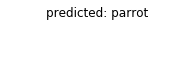

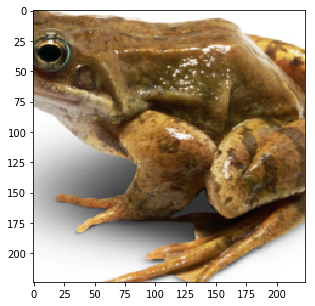

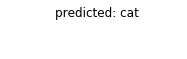

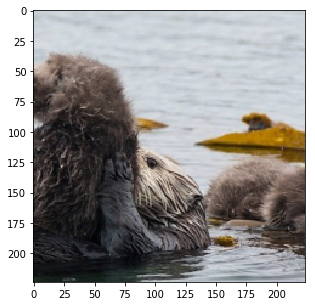

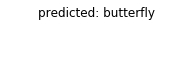

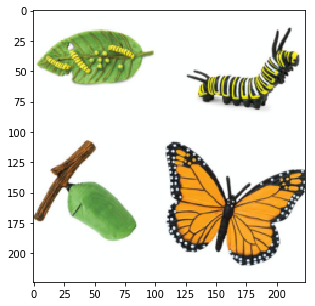

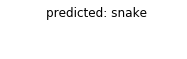

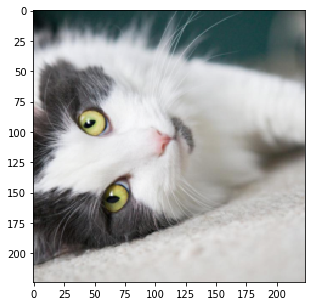

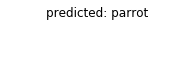

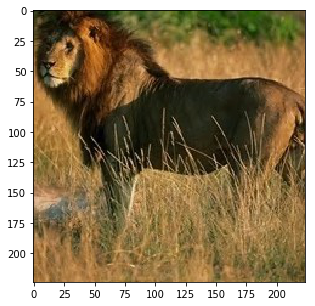

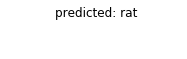

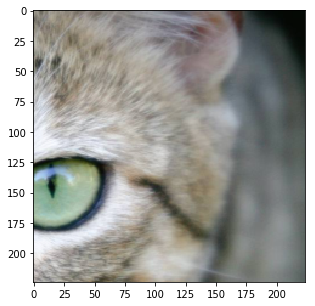

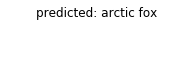

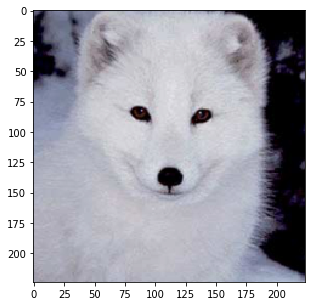

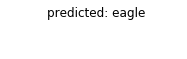

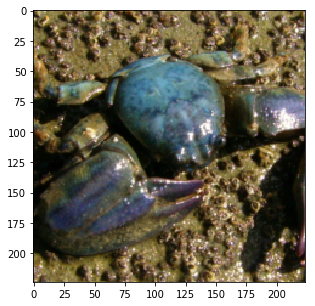

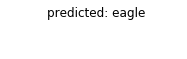

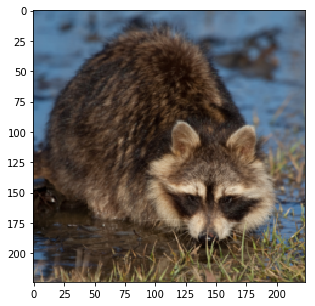

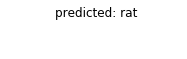

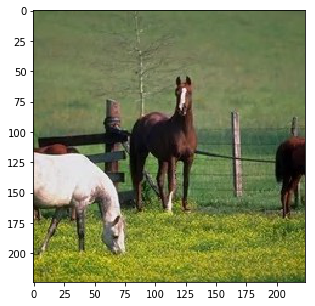

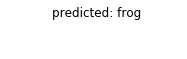

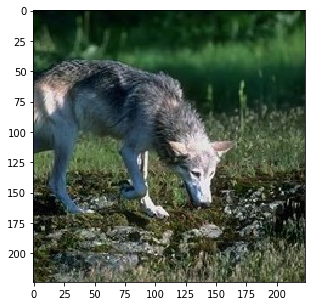

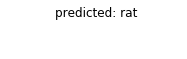

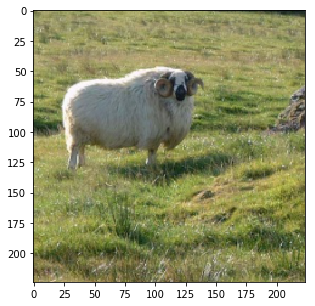

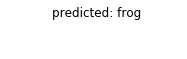

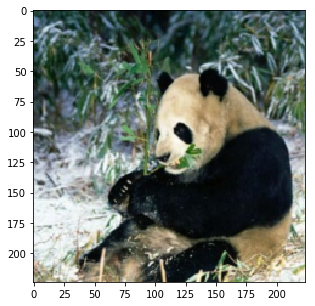

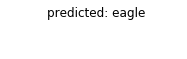

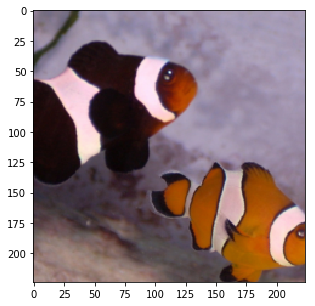

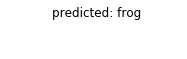

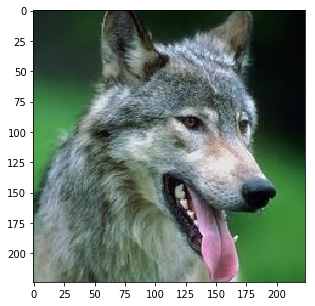

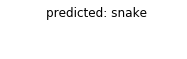

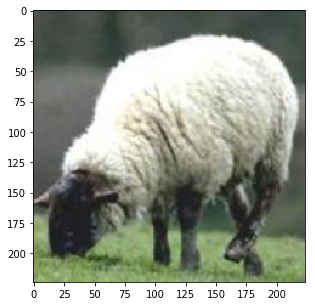

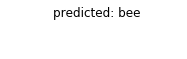

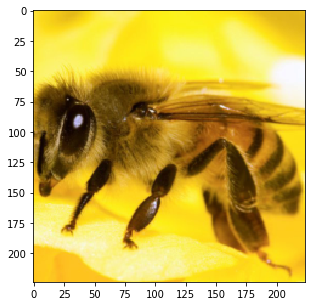

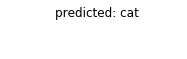

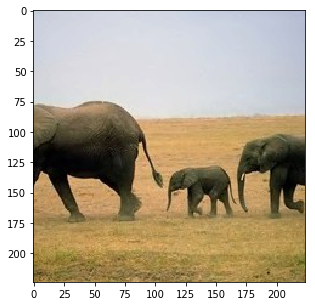

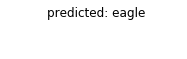

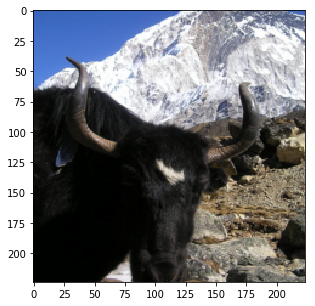

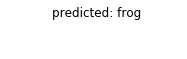

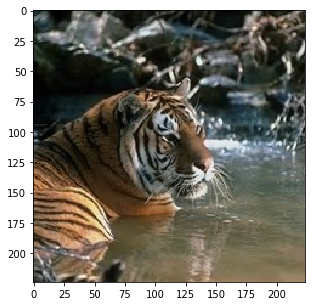

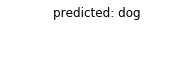

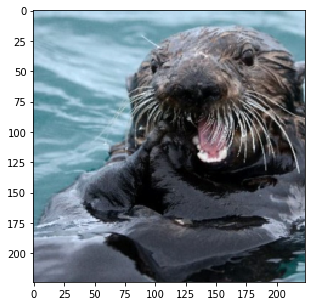

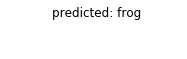

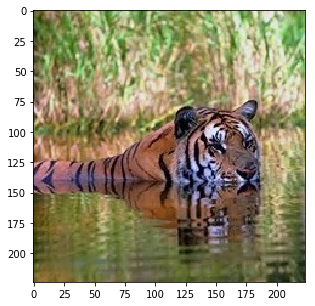

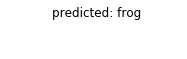

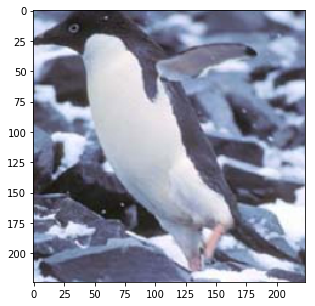

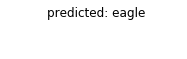

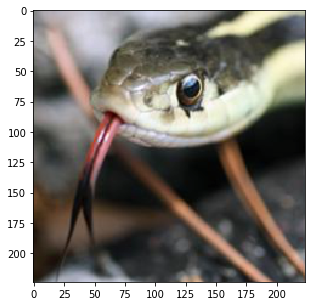

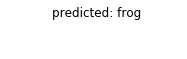

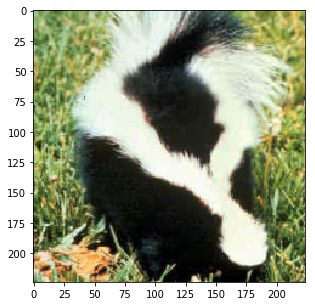

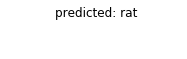

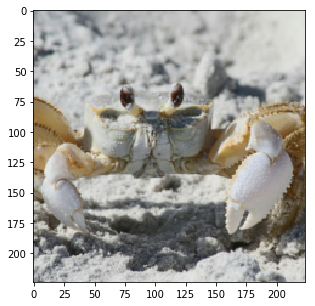

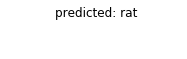

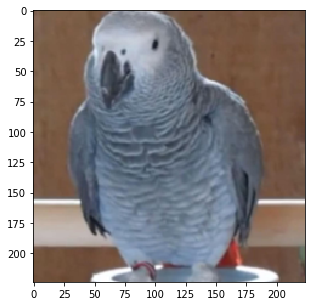

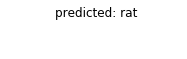

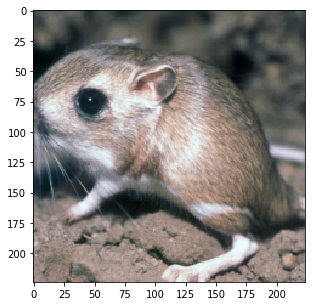

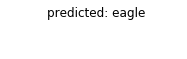

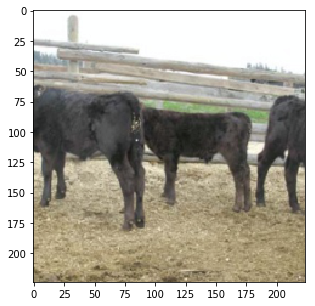

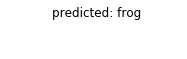

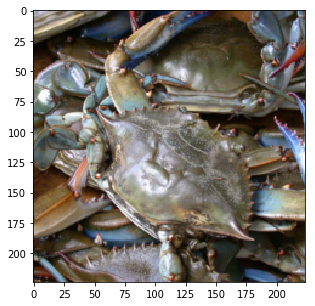

In [13]:
#Training the model
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=1)

torch.save(model_ft.state_dict(), os.getcwd()+"/best_animal_resnet.pth")
print("Model saved")

print('-'*20)
print("Printing Images")
visualize_model(model_ft, 30)

In [ ]:
visualize_model(model_ft, 30)